In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import warnings
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Suppress the PyTorch deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
image_path = 'dataset/heat_treatment/image'
data_path = 'average_gray_values.csv'

In [3]:
# image argumentation
train_argumentations = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_argumentations = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# dataset perparation
class IM2PROPDataset(Dataset):
    def __init__(self, csv_dir, image_dir, transform=None):
        self.data = pd.read_csv(csv_dir)
        self.img_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        target = self.data.iloc[idx, 1] / 255.0  # avg_gray_value


        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        target = torch.tensor(target, dtype=torch.float32)
        return image, target

In [5]:
df = pd.read_csv(data_path)

train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)

# Save temporary CSVs for simplicity
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

train_dataset = IM2PROPDataset('train.csv', image_dir=image_path, transform=train_argumentations)
val_dataset = IM2PROPDataset('val.csv', image_dir=image_path, transform=test_argumentations)
test_dataset = IM2PROPDataset('test.csv', image_dir=image_path, transform=test_argumentations)

print(f"Train images: {len(train_dataset)}")
print(f"Val images  : {len(val_dataset)}")
print(f"Test images : {len(test_dataset)}")
print(f"Total       : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")

Train images: 158
Val images  : 29
Test images : 33
Total       : 220


In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# --- 1. Define the Custom Regression Head (Decoder) ---
class RegressionHead(nn.Module):
    """
    The decoder part of the model, which performs aggregation and
    final dimensionality reduction from the 2048 feature channels to a single scalar.
    """
    def __init__(self, final_output_dim=1):
        super().__init__()
        
        # Spatial Aggregation: Global Average Pooling (GAP)
        # Input: [B, 2048, H, W] -> Output: [B, 2048, 1, 1]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Channel-wise Dimensionality Reduction: Linear Layers
        self.regressor = nn.Sequential(
            # Input size is 2048 (from GAP)
            nn.Linear(2048, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            # nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, final_output_dim)  # Final output layer
        )

    def forward(self, x):
        # x shape: [B, 2048, H, W]
        x = self.avgpool(x)       # Shape: [B, 2048, 1, 1]
        x = torch.flatten(x, 1)   # Shape: [B, 2048] (The latent feature vector)
        output = self.regressor(x)
        
        return output

# --- 2. Define the Complete Model Wrapper ---
class MicroNetRegressor(nn.Module):
    """
    Combines the pre-trained ResNet encoder features with the new Regression Head.
    """
    def __init__(self, pre_trained_base_model):
        super().__init__()
        
        # --- ENCODER (The pre-trained feature extractor) ---
        # We explicitly assemble the layers that constitute the ResNet feature backbone.
        # This excludes the original 'avgpool' and 'fc' classification layers.
        self.encoder_features = nn.Sequential(
            pre_trained_base_model.conv1, 
            pre_trained_base_model.bn1, 
            pre_trained_base_model.relu, 
            pre_trained_base_model.maxpool, 
            pre_trained_base_model.layer1, 
            pre_trained_base_model.layer2, 
            pre_trained_base_model.layer3, 
            pre_trained_base_model.layer4
        )
        
        # --- DECODER / REGRESSION HEAD (The new, trainable part) ---
        self.regression_head = RegressionHead(final_output_dim=1)

    def forward(self, x):
        # 1. Pass input through the pre-trained encoder
        x = self.encoder_features(x)  # Output is the deep feature map: [B, 2048, H, W]
        
        # 2. Pass feature map through the custom head for regression
        output = self.regression_head(x) # Output is the scalar prediction: [B, 1]
        
        return output
    
# --- 3. Model Initialization and Loading ---

# Configuration
encoder_name = 'resnet50'
weights_source = 'micronet'

print(f"Loading {encoder_name} architecture...")
# Initialize the base PyTorch ResNet-50 model (un-initialized, as we load custom weights later)
# Using weights=None to comply with the new PyTorch API
base_model = torch.hub.load('pytorch/vision:v0.10.0', encoder_name, weights=None)

# Get the URL for the MicroNet pre-trained weights
url = pmm.util.get_pretrained_microscopynet_url(encoder=encoder_name, encoder_weights=weights_source)

print(f"Loading MicroNet weights from: {url}")
# Load the MicroNet state dictionary into the ResNet-50 model
base_model.load_state_dict(model_zoo.load_url(url))

# 4. Instantiate the Final Regression Model
model_regressor = MicroNetRegressor(pre_trained_base_model=base_model)
model_regressor.eval() # Set model to evaluation mode (important for BN layers)

# --- 5. Optional: Freeze the Encoder Layers ---
# Freeze all encoder weights to only train the new regression head initially
for name, param in model_regressor.named_parameters():
    if name.startswith('encoder_features'):
        param.requires_grad = False
    
# Check which parameters are trainable
total_params = sum(p.numel() for p in model_regressor.parameters())
trainable_params = sum(p.numel() for p in model_regressor.parameters() if p.requires_grad)

Loading resnet50 architecture...


Using cache found in /home/jay/.cache/torch/hub/pytorch_vision_v0.10.0


Loading MicroNet weights from: https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.1.pth.tar


In [8]:
# --- 3. Model Initialization and Loading ---

# Configuration
encoder_name = 'resnet50'
weights_source = 'micronet'

print(f"Loading {encoder_name} architecture...")
# Initialize the base PyTorch ResNet-50 model (un-initialized, as we load custom weights later)
# Using weights=None to comply with the new PyTorch API
base_model = torch.hub.load('pytorch/vision:v0.10.0', encoder_name, weights=None)

# Get the URL for the MicroNet pre-trained weights
url = pmm.util.get_pretrained_microscopynet_url(encoder=encoder_name, encoder_weights=weights_source)

print(f"Loading MicroNet weights from: {url}")
# Load the MicroNet state dictionary into the ResNet-50 model
base_model.load_state_dict(model_zoo.load_url(url))

# 4. Instantiate the Final Regression Model
model_regressor = MicroNetRegressor(pre_trained_base_model=base_model)

# --- 5. Optional: Freeze the Encoder Layers ---
# Freeze all encoder weights to only train the new regression head initially
for name, param in model_regressor.named_parameters():
    if name.startswith('encoder_features'):
        param.requires_grad = False
    
# Check which parameters are trainable
total_params = sum(p.numel() for p in model_regressor.parameters())
trainable_params = sum(p.numel() for p in model_regressor.parameters() if p.requires_grad)

print("\n--- Model Summary ---")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters (Regression Head): {trainable_params:,}")
print(f"Encoder Layers Frozen: {total_params - trainable_params:,}")

Loading resnet50 architecture...
Loading MicroNet weights from: https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.1.pth.tar


Using cache found in /home/jay/.cache/torch/hub/pytorch_vision_v0.10.0



--- Model Summary ---
Total Parameters: 26,200,129
Trainable Parameters (Regression Head): 2,692,097
Encoder Layers Frozen: 23,508,032


In [9]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_regressor = model_regressor.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_regressor.parameters()), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # optional

In [10]:
# --- 3. Training Loop ---
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for images, targets in tqdm(dataloader, desc="Training", leave=False):
        images, targets = images.to(device), targets.to(device).unsqueeze(1)  # [B, 1]
        
        optimizer.zero_grad()
        outputs = model(images)              # forward pass -> [B, 1]
        loss = criterion(outputs, targets)   # MSE loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds, trues = [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation", leave=False):
            images, targets = images.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images)
            
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    preds_scaled = np.concatenate(preds).squeeze()
    trues_scaled = np.concatenate(trues).squeeze()

    preds_255 = preds_scaled * 255.0
    trues_255 = trues_scaled * 255.0

    mse_255 = np.mean((preds_255 - trues_255) ** 2)
    mae_255 = np.mean(np.abs(preds_255 - trues_255))
    r2 = 1 - (np.sum((preds_255 - trues_255) ** 2) / np.sum((trues_255 - np.mean(trues_255)) ** 2 + 1e-8))

    return epoch_loss, mae_255, mse_255, r2


Epoch [1/50]


Train Loss: 0.9778 | Val Loss: 0.3401 | Val MAE: 146.4901 | Val MSE: 22112.0801 | Val R²: -37.1600
✅ Saved new best model

Epoch [2/50]


Train Loss: 0.3954 | Val Loss: 0.2647 | Val MAE: 128.8018 | Val MSE: 17209.2969 | Val R²: -28.6990
✅ Saved new best model

Epoch [3/50]


Train Loss: 0.1252 | Val Loss: 0.1293 | Val MAE: 89.4419 | Val MSE: 8405.0957 | Val R²: -13.5051
✅ Saved new best model

Epoch [4/50]


Train Loss: 0.0410 | Val Loss: 0.0861 | Val MAE: 69.6869 | Val MSE: 5597.8965 | Val R²: -8.6606
✅ Saved new best model

Epoch [5/50]


Train Loss: 0.0431 | Val Loss: 0.0834 | Val MAE: 44.6593 | Val MSE: 5422.1650 | Val R²: -8.3573
✅ Saved new best model

Epoch [6/50]


Train Loss: 0.0462 | Val Loss: 0.0750 | Val MAE: 50.5513 | Val MSE: 4873.9761 | Val R²: -7.4113
✅ Saved new best model

Epoch [7/50]


Train Loss: 0.0377 | Val Loss: 0.0270 | Val MAE: 29.8426 | Val MSE: 1755.9235 | Val R²: -2.0303
✅ Saved new best model

Epoch [8/50]


Train Loss: 0.0196 | Val Loss: 0.0093 | Val MAE: 22.0474 | Val MSE: 604.7363 | Val R²: -0.0436
✅ Saved new best model

Epoch [9/50]


Train Loss: 0.0141 | Val Loss: 0.0059 | Val MAE: 16.5994 | Val MSE: 383.0772 | Val R²: 0.3389
✅ Saved new best model

Epoch [10/50]


Train Loss: 0.0098 | Val Loss: 0.0050 | Val MAE: 14.6393 | Val MSE: 326.6013 | Val R²: 0.4364
✅ Saved new best model

Epoch [11/50]


Train Loss: 0.0099 | Val Loss: 0.0106 | Val MAE: 20.9738 | Val MSE: 691.8715 | Val R²: -0.1940

Epoch [12/50]


Train Loss: 0.0063 | Val Loss: 0.0076 | Val MAE: 18.2499 | Val MSE: 491.5926 | Val R²: 0.1516

Epoch [13/50]


Train Loss: 0.0070 | Val Loss: 0.0041 | Val MAE: 10.9779 | Val MSE: 267.7629 | Val R²: 0.5379
✅ Saved new best model

Epoch [14/50]


Train Loss: 0.0057 | Val Loss: 0.0043 | Val MAE: 12.6837 | Val MSE: 282.3018 | Val R²: 0.5128

Epoch [15/50]


Train Loss: 0.0067 | Val Loss: 0.0064 | Val MAE: 16.7460 | Val MSE: 413.8881 | Val R²: 0.2857

Epoch [16/50]


Train Loss: 0.0068 | Val Loss: 0.0153 | Val MAE: 27.9092 | Val MSE: 993.7583 | Val R²: -0.7150

Epoch [17/50]


Train Loss: 0.0074 | Val Loss: 0.0056 | Val MAE: 16.4157 | Val MSE: 367.0822 | Val R²: 0.3665

Epoch [18/50]


Train Loss: 0.0070 | Val Loss: 0.0088 | Val MAE: 17.5772 | Val MSE: 574.1373 | Val R²: 0.0092

Epoch [19/50]


Train Loss: 0.0048 | Val Loss: 0.0075 | Val MAE: 18.6413 | Val MSE: 489.0050 | Val R²: 0.1561

Epoch [20/50]


Train Loss: 0.0045 | Val Loss: 0.0068 | Val MAE: 16.9381 | Val MSE: 439.5149 | Val R²: 0.2415

Epoch [21/50]


Train Loss: 0.0041 | Val Loss: 0.0047 | Val MAE: 14.6434 | Val MSE: 308.0426 | Val R²: 0.4684

Epoch [22/50]


Train Loss: 0.0043 | Val Loss: 0.0053 | Val MAE: 15.1812 | Val MSE: 344.3742 | Val R²: 0.4057

Epoch [23/50]


Train Loss: 0.0050 | Val Loss: 0.0015 | Val MAE: 8.3427 | Val MSE: 97.2088 | Val R²: 0.8322
✅ Saved new best model

Epoch [24/50]


Train Loss: 0.0049 | Val Loss: 0.0035 | Val MAE: 12.6349 | Val MSE: 229.3504 | Val R²: 0.6042

Epoch [25/50]


Train Loss: 0.0049 | Val Loss: 0.0019 | Val MAE: 8.9973 | Val MSE: 126.0782 | Val R²: 0.7824

Epoch [26/50]


Train Loss: 0.0050 | Val Loss: 0.0016 | Val MAE: 8.9092 | Val MSE: 105.7691 | Val R²: 0.8175

Epoch [27/50]


Train Loss: 0.0040 | Val Loss: 0.0057 | Val MAE: 15.8088 | Val MSE: 367.6262 | Val R²: 0.3656

Epoch [28/50]


Train Loss: 0.0034 | Val Loss: 0.0033 | Val MAE: 11.6370 | Val MSE: 212.4208 | Val R²: 0.6334

Epoch [29/50]


Train Loss: 0.0034 | Val Loss: 0.0031 | Val MAE: 11.7302 | Val MSE: 202.8986 | Val R²: 0.6498

Epoch [30/50]


Train Loss: 0.0032 | Val Loss: 0.0028 | Val MAE: 11.3516 | Val MSE: 185.2487 | Val R²: 0.6803

Epoch [31/50]


Train Loss: 0.0041 | Val Loss: 0.0040 | Val MAE: 14.6626 | Val MSE: 261.7472 | Val R²: 0.5483

Epoch [32/50]


Train Loss: 0.0028 | Val Loss: 0.0045 | Val MAE: 14.8560 | Val MSE: 294.7360 | Val R²: 0.4914

Epoch [33/50]


Train Loss: 0.0034 | Val Loss: 0.0109 | Val MAE: 19.8764 | Val MSE: 710.3723 | Val R²: -0.2259

Epoch [34/50]


Train Loss: 0.0036 | Val Loss: 0.0031 | Val MAE: 11.6542 | Val MSE: 201.8203 | Val R²: 0.6517

Epoch [35/50]


Train Loss: 0.0040 | Val Loss: 0.0047 | Val MAE: 15.4376 | Val MSE: 308.1176 | Val R²: 0.4683

Epoch [36/50]


Train Loss: 0.0028 | Val Loss: 0.0057 | Val MAE: 16.9983 | Val MSE: 368.7132 | Val R²: 0.3637

Epoch [37/50]


Train Loss: 0.0029 | Val Loss: 0.0110 | Val MAE: 25.1849 | Val MSE: 717.1410 | Val R²: -0.2376

Epoch [38/50]


Train Loss: 0.0030 | Val Loss: 0.0071 | Val MAE: 19.1300 | Val MSE: 462.4096 | Val R²: 0.2020

Epoch [39/50]


Train Loss: 0.0036 | Val Loss: 0.0035 | Val MAE: 12.5563 | Val MSE: 225.4092 | Val R²: 0.6110

Epoch [40/50]


Train Loss: 0.0027 | Val Loss: 0.0021 | Val MAE: 8.2419 | Val MSE: 139.1032 | Val R²: 0.7599

Epoch [41/50]


Train Loss: 0.0027 | Val Loss: 0.0023 | Val MAE: 8.9199 | Val MSE: 147.2357 | Val R²: 0.7459

Epoch [42/50]


Train Loss: 0.0025 | Val Loss: 0.0054 | Val MAE: 16.1763 | Val MSE: 353.2350 | Val R²: 0.3904

Epoch [43/50]


Train Loss: 0.0028 | Val Loss: 0.0045 | Val MAE: 14.6549 | Val MSE: 291.7738 | Val R²: 0.4965

Epoch [44/50]


Train Loss: 0.0021 | Val Loss: 0.0032 | Val MAE: 12.2063 | Val MSE: 207.7765 | Val R²: 0.6414

Epoch [45/50]


Train Loss: 0.0024 | Val Loss: 0.0043 | Val MAE: 13.8716 | Val MSE: 278.0605 | Val R²: 0.5201

Epoch [46/50]


Train Loss: 0.0028 | Val Loss: 0.0021 | Val MAE: 9.8182 | Val MSE: 138.0520 | Val R²: 0.7618

Epoch [47/50]


Train Loss: 0.0030 | Val Loss: 0.0022 | Val MAE: 9.3908 | Val MSE: 142.0170 | Val R²: 0.7549

Epoch [48/50]


Train Loss: 0.0027 | Val Loss: 0.0036 | Val MAE: 11.4333 | Val MSE: 234.0898 | Val R²: 0.5960

Epoch [49/50]


Train Loss: 0.0023 | Val Loss: 0.0015 | Val MAE: 7.5787 | Val MSE: 95.3821 | Val R²: 0.8354
✅ Saved new best model

Epoch [50/50]


Train Loss: 0.0022 | Val Loss: 0.0054 | Val MAE: 17.2615 | Val MSE: 349.4649 | Val R²: 0.3969

Training complete!


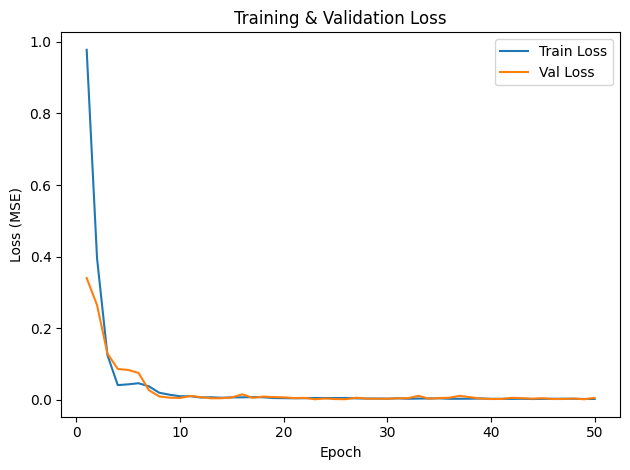

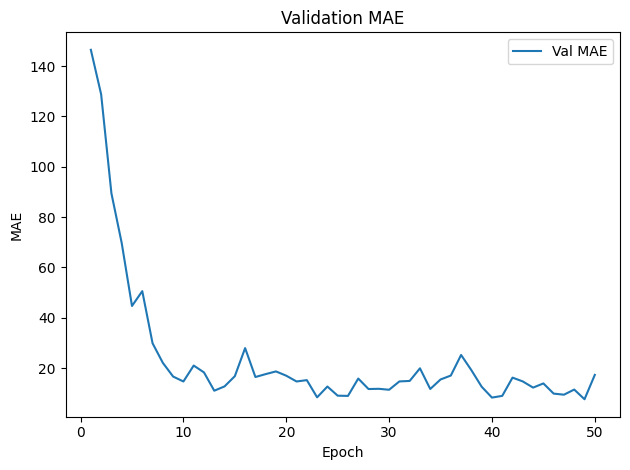

Saved plots: loss_curves.png, val_mae_curve.png


In [11]:
num_epochs = 50
best_val_loss = float('inf')

# histories
hist_train_loss = []
hist_val_loss = []
hist_val_mae  = []

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    train_loss = train_one_epoch(model_regressor, train_loader, optimizer, criterion, device)
    val_loss, val_mae, val_mse, r2 = validate_one_epoch(model_regressor, val_loader, criterion, device)
    
    # Step the scheduler
    # If you're using StepLR / CosineAnnealingLR:
    # scheduler.step()
    # If you're using ReduceLROnPlateau, use this instead:
    # scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val MSE: {val_mse:.4f} | Val R²: {r2:.4f}")

    # record history
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    hist_val_mae.append(val_mae)
    
    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_regressor.state_dict(), "best_regression_model.pt")
        print("✅ Saved new best model")

print("\nTraining complete!")

# ---- Plot curves ----
# Loss curves
plt.figure()
plt.plot(range(1, num_epochs+1), hist_train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), hist_val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig('loss_curves.png', dpi=200)
plt.show()

# (Optional) MAE curve
plt.figure()
plt.plot(range(1, num_epochs+1), hist_val_mae, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()
plt.tight_layout()
plt.savefig('val_mae_curve.png', dpi=200)
plt.show()

print("Saved plots: loss_curves.png, val_mae_curve.png")


In [12]:
# Load model
model_regressor.load_state_dict(torch.load("best_regression_model.pt", map_location=device))
model_regressor.to(device)
model_regressor.eval()  # VERY IMPORTANT for inference

def test_model(model, dataloader, device):
    model.eval()
    preds, trues, names = [], [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Testing"):
            images, targets = images.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images)

            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())

    preds_scaled = np.concatenate(preds).squeeze()
    trues_scaled = np.concatenate(trues).squeeze()

    preds_255 = preds_scaled * 255.0
    trues_255 = trues_scaled * 255.0

    mse = np.mean((preds_255 - trues_255) ** 2)
    mae = np.mean(np.abs(preds_255 - trues_255))
    r2  = 1 - (np.sum((preds_255 - trues_255) ** 2) / np.sum((trues_255 - np.mean(trues_255)) ** 2 + 1e-8))

    print("\n--- Test Results ---")
    print(f"MSE : {mse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    return preds_255, trues_255

preds, trues = test_model(model_regressor, test_loader, device)


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


--- Test Results ---
MSE : 70.4734
MAE : 7.2170
R²  : 0.8551


In [13]:
# A. Scale mismatch?
imgs, y = next(iter(train_loader))
with torch.no_grad():
    p = model_regressor(imgs.to(device)).cpu().squeeze()
print("targets range:", y.min().item()* 255.0, y.max().item()* 255.0)    # expect ~0..255
print("preds   range:", p.min().item()* 255.0, p.max().item()* 255.0)    # should be similar scale


targets range: 140.15481054782867 220.31185895204544
preds   range: 136.0208147764206 206.1583176255226
